In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse

from model import *

In [63]:
# args
args = dict()
args['data_sample_size'] = 5000
args['node_size'] = 10
args['graph_degree'] = 2
args['graph_dist'] = 'normal'
args['graph_scale'] = 1.0
args['graph_mean'] = 0.0
args['graph_linear_type'] = 'linear'
args['dependence_type'] = 0
args['dependence_prop'] = 0.5
args['optimizer'] = 'Adam'
args['graph_threshold'] = 0.3
args['tau_A'] = 0.0
args['lambda_A'] = 0.0
args['c_A'] = 1
args['use_A_connect_loss'] = 0
args['use_A_positiver_loss'] = 0
args['cuda'] = 0
args['seed'] = 42
args['epochs'] = 300
args['batch_size'] = 100
args['lr'] = 3e-3
args['encoder_hidden'] = 64
args['decoder_hidden'] = 64
args['temp'] = 0.5
args['k_max_iter'] = 100
args['encoder_dropout'] = 0.0
args['decoder_dropout'] = 0.0
args['lr_decay'] = 200
args['gamma'] = 1.0
args['h_tol'] = 1e-8
args['x_dims'] = 1
args['z_dims'] = 1
args['z_size'] = args['node_size']# the number of latent variables

# to argparser
parser = argparse.ArgumentParser()
for key, value in args.items():
    parser.add_argument('--'+key, default=value, type=type(value))

In [64]:
args = parser.parse_args(args=[])

In [65]:
adj_A = np.zeros([args.node_size, args.node_size])
vae = VAE(args=args, adj_A=adj_A)

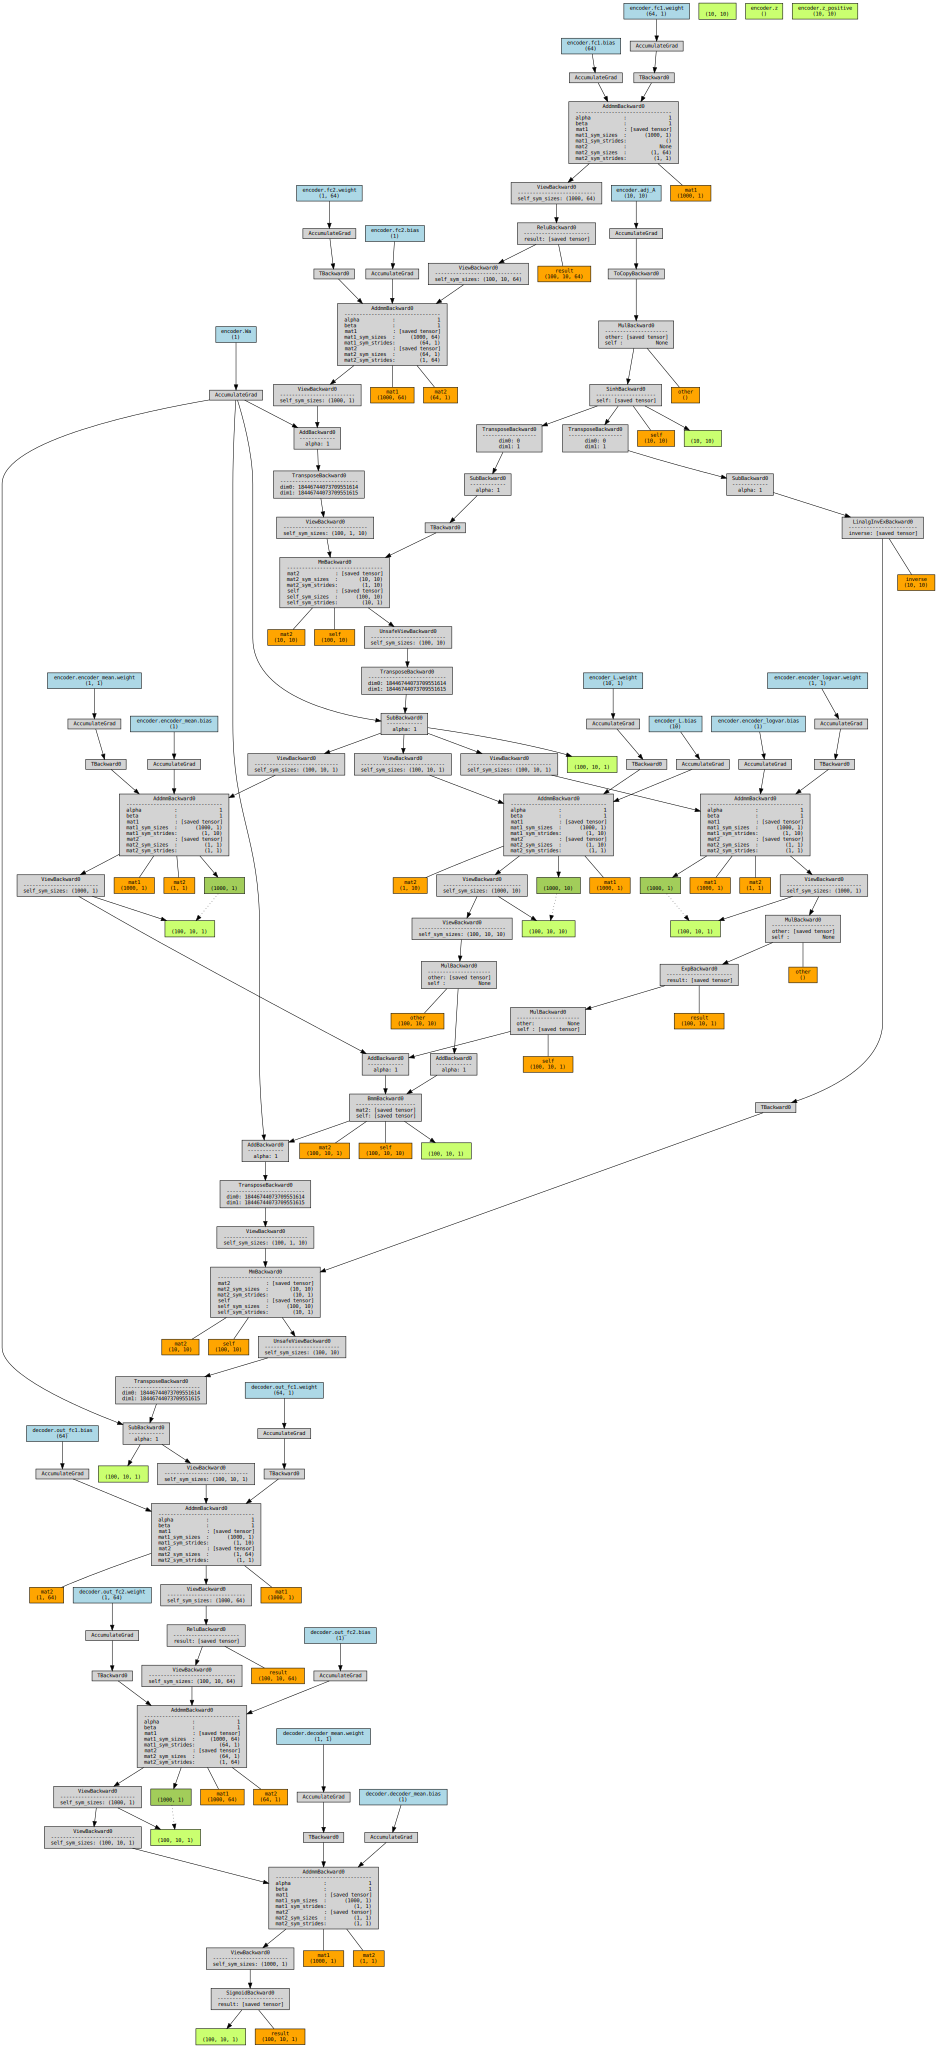

In [66]:
x = torch.zeros(args.batch_size, args.node_size, args.x_dims)

make_dot(vae(x), params=dict(vae.named_parameters()), show_attrs=True, show_saved=True)

In [68]:
import hiddenlayer as hl

hl.build_graph(vae, torch.zeros(args.batch_size, args.node_size, args.x_dims))

/Users/dangchan/Desktop/Github/NFG-VAE/model.py:76: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.sum(self.adj_A != self.adj_A):


RuntimeError: output 1 (0
[ CPUDoubleType{} ]) of traced region did not have observable data dependence with trace inputs; this probably indicates your program cannot be understood by the tracer.

In [36]:
from modules import *

encoder = MLPEncoder(args.node_size * args.x_dims, args.x_dims, args.encoder_hidden,
                         int(args.z_dims), adj_A,
                         batch_size = args.batch_size,
                         do_prob = args.encoder_dropout, factor = 1).double()

decoder = MLPDecoder(args.node_size * args.x_dims,
                         args.z_dims, args.x_dims, encoder,
                         data_variable_size = args.node_size,
                         batch_size = args.batch_size,
                         n_hid=args.decoder_hidden,
                         do_prob=args.decoder_dropout).double()

In [39]:
off_diag = np.ones([args.node_size, args.node_size]) - np.eye(args.node_size)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float64)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float64)
rel_rec = torch.DoubleTensor(rel_rec)
rel_send = torch.DoubleTensor(rel_send)

In [54]:
class vae_daggnn(nn.Module):
    def __init__(self, encoder, decoder, rel_rec, rel_send, args):
        super(vae_daggnn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rel_rec = rel_rec
        self.rel_send = rel_send
        self.args = args

    def forward(self, x):
        enc_x, logits, origin_A, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(x, rel_rec, rel_send)  # logits is of size: [num_sims, z_dims]
        edges = logits

        dec_x, output, adj_A_tilt_decoder = decoder(x, edges, args.node_size * args.x_dims, rel_rec, rel_send, origin_A, adj_A_tilt_encoder, Wa)

        return dec_x, output, adj_A_tilt_decoder, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa

In [55]:
vae_new = vae_daggnn(encoder, decoder, rel_rec, rel_send, args)

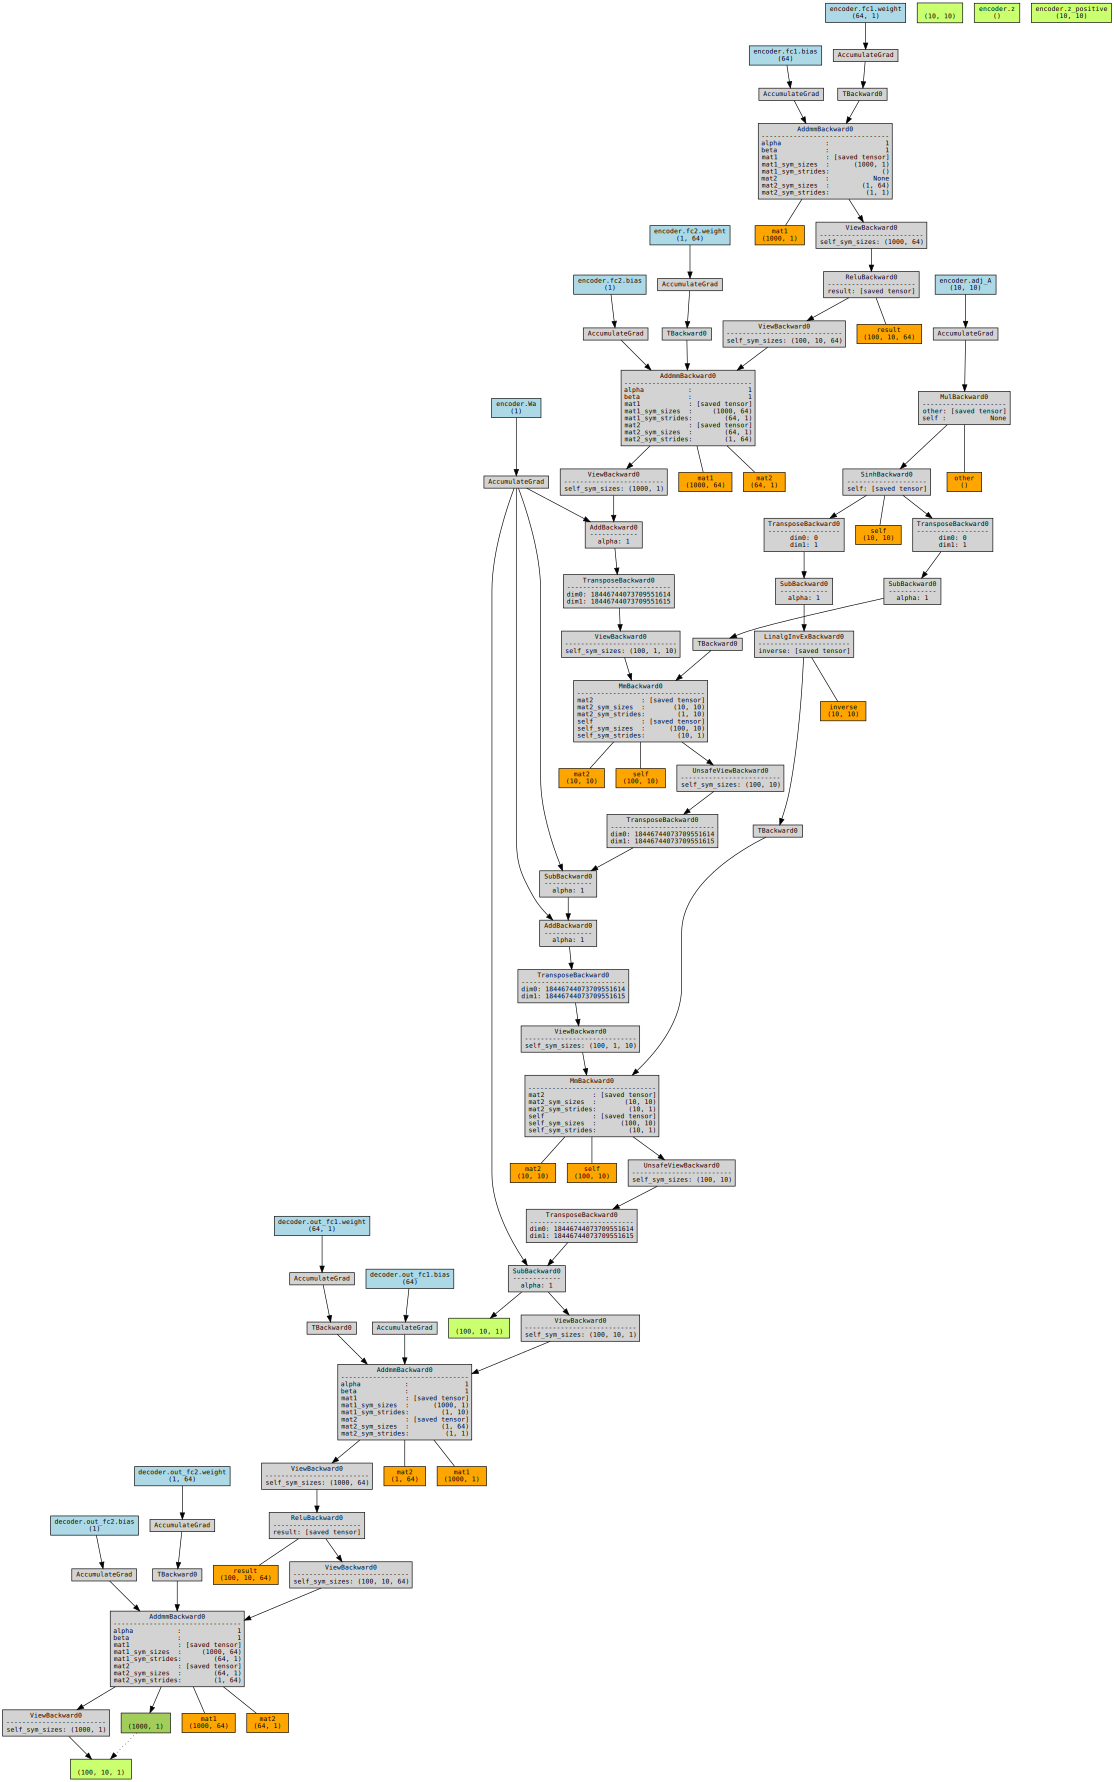

In [60]:
make_dot(vae_new(x.double()), params=dict(vae_new.named_parameters()), show_attrs=True, show_saved=True)